In [35]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import zscore

### DataPreprocessing

In [36]:
wine_data_frame = pd.read_csv('winequality-white.csv', sep = ";")
wine_data_frame.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [37]:
num_features = len(wine_data_frame.columns)
num_features

12

In [38]:
print(wine_data_frame.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [39]:
def preprocess_inputs(df, label_column):
    df = df.copy()
    
    # Split df into X and y
    Y = df[label_column]
    X = df.drop(label_column, axis=1)
    
    X = X.apply(zscore)
    
    Y = torch.tensor(Y.values, dtype=torch.float32).reshape(-1, 1)
    X = torch.tensor(X.values, dtype=torch.float32)
    
    # Train-test split
    trainX, testX, trainY, testY = train_test_split(X, Y, train_size=0.8, shuffle=True, random_state=1)
    
    return trainX, testX, trainY, testY

In [40]:
trainX, testX, trainY, testY = preprocess_inputs(wine_data_frame, 'quality')

In [41]:
trainX, trainY

(tensor([[-0.6575,  0.0175, -0.3652,  ...,  1.6010,  0.8777,  0.3947],
         [ 0.5276, -0.4787,  0.2959,  ...,  0.4751, -0.7873,  1.3700],
         [-0.3020,  1.0097, -1.5222,  ..., -0.5184, -0.9626, -0.2554],
         ...,
         [ 1.8313, -0.8755,  0.7091,  ..., -0.8495,  1.4034,  0.4760],
         [-0.8945, -0.5779, -0.6958,  ...,  0.1439, -0.7873,  0.1509],
         [ 0.4091, -0.4787,  0.3786,  ..., -0.6508, -0.4368, -1.2306]]),
 tensor([[6.],
         [8.],
         [6.],
         ...,
         [4.],
         [5.],
         [6.]]))

In [42]:
testX, testY

(tensor([[-0.7760,  1.0097, -1.2742,  ...,  2.2634,  1.9292, -1.0681],
         [-0.5390, -0.2802,  3.3536,  ...,  0.1439, -0.6121, -1.0681],
         [-0.5390, -0.2802,  0.2959,  ..., -0.0548, -0.7873,  0.4760],
         ...,
         [ 0.4091,  0.2159, -0.6131,  ...,  0.0115,  0.6148,  0.6386],
         [-0.1834, -1.6693,  0.0480,  ...,  1.5348, -0.7873, -0.9868],
         [-0.3020,  0.1167, -0.1999,  ...,  0.3426,  0.9653,  1.6950]]),
 tensor([[4.],
         [6.],
         [7.],
         [5.],
         [7.],
         [6.],
         [6.],
         [6.],
         [7.],
         [5.],
         [6.],
         [7.],
         [6.],
         [6.],
         [6.],
         [5.],
         [7.],
         [6.],
         [5.],
         [6.],
         [5.],
         [5.],
         [6.],
         [7.],
         [6.],
         [5.],
         [4.],
         [5.],
         [6.],
         [7.],
         [5.],
         [6.],
         [7.],
         [6.],
         [7.],
         [5.],
         [5.],
   

### Model

In [43]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()

        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.dropout(x, 0.4, True)
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [44]:
input_dim = trainX.shape[1]

In [45]:
model = MLP(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [46]:
epochs = 1000
losses = []

In [47]:
# training the model
for epoch in range(epochs):
    optimizer.zero_grad()

    outputs = model(trainX)
    loss = criterion(outputs, trainY)
    loss.backward()

    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}/{epochs} - Loss : {loss.item():.2f}')

    losses.append(loss.item())

model.eval()
with torch.no_grad():
    test_outputs = model(testX)
    test_loss = criterion(test_outputs, testY)
    print(f'Test Loss : {test_loss.item():.2f}')


Epoch 100/1000 - Loss : 2.59
Epoch 200/1000 - Loss : 1.53
Epoch 300/1000 - Loss : 1.08
Epoch 400/1000 - Loss : 0.87
Epoch 500/1000 - Loss : 0.64
Epoch 600/1000 - Loss : 0.55
Epoch 700/1000 - Loss : 0.51
Epoch 800/1000 - Loss : 0.50
Epoch 900/1000 - Loss : 0.48
Epoch 1000/1000 - Loss : 0.49
Test Loss : 0.53


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


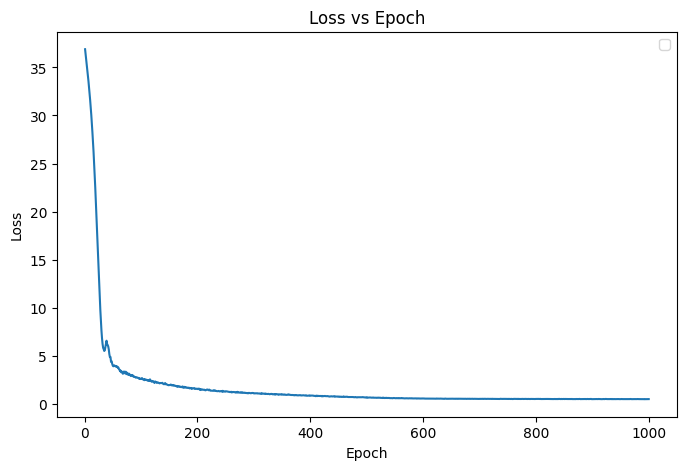

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.show()